In [ ]:
# default_exp datasets.bases.session

# Session Datasets
> Implementation of session dataset modules.

In [1]:
#export
import os
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from recohut.visualization.basic_plots import BasicVisual

In [2]:
#exporti
class ItemPopularityPlot(BasicVisual):
    def __init__(self, item_counts, **kwargs):
        self.item_counts = item_counts
        super().__init__(**kwargs)

    def plot(self):
        self.ax = plt.semilogy(sorted(self.item_counts))

In [3]:
#exporti
class SessionLengthPlot(BasicVisual):
    def __init__(self, session_lengths, **kwargs):
        self.session_lengths = session_lengths
        super().__init__(**kwargs)

    def plot(self):
        sns.boxplot(x=self.session_lengths, ax=self.ax)
        for patch in self.ax.artists:
            r, g, b, a = patch.get_facecolor()
            patch.set_facecolor((r, g, b, .7))

In [33]:
#export
class SessionData:
    def __init__(self, df, session_col='SESSIONID', item_col='ITEMID', *args, **kwargs):
        self.df = df
        self.session_col = session_col
        self.item_col = item_col
        self.df.dropna(inplace=True)
    
    def filter_short_sessions(self, min_session_length: int = 3):
        item_counts = self.df.groupby([self.session_col]).count()[self.item_col]
        self.df = self.df[self.df[self.session_col].isin(item_counts[item_counts >= min_session_length].index)].reset_index(drop=True)

    def get_session_sequences(self):
        """
        Construct a list of lists
    
        Example:
            Given a df that looks like 
            SessionID |   ItemID 
            ----------------------
                1     |     111
                1     |     123
                1     |     345
                2     |     045 
                2     |     334
                2     |     342
                2     |     8970
                2     |     345
            
            Retrun a list of lists like this: 
            sessions = [
                    ['111', '123', '345'],
                    ['045', '334', '342', '8970', '345'],
            ]
        """
        grp_by_session = self.df.groupby([self.session_col])
        session_sequences = []
        for name, group in grp_by_session:
            session_sequences.append(list(group[self.item_col].values))
        return session_sequences

    def get_split_next_event_prediction(self, session_sequences = None, test_size: int = 10000):
        """
        Next Event Prediction (NEP) does not necessarily follow the traditional train/test split. 
        Instead training is perform on the first n-1 items in a session sequence of n items. 
        The test set is constructed of (n-1, n) "query" pairs where the n-1 item is used to generate 
        recommendation predictions and it is checked whether the nth item is included in those recommendations. 
        Example:
            Given a session sequence ['045', '334', '342', '8970', '128']
            Training is done on ['045', '334', '342', '8970']
            Testing (and validation) is done on ['8970', '128']
        
        Test and Validation sets are constructed to be disjoint. 
        """
        if session_sequences is None:
            session_sequences = self.get_session_sequences()
        ## Construct training set
        # use (1 st, ..., n-1 th) items from each session sequence to form the train set (drop last item)
        train = [sess[:-1] for sess in session_sequences]

        if test_size > len(train):
            print(
                f"Test set cannot be larger than train set. Train set contains {len(train)} sessions."
            )
            return

        ### Construct test and validation sets
        # sub-sample 10k sessions, and use (n-1 th, n th) pairs of items from session_squences to form the
        # disjoint validaton and test sets
        test_validation = [sess[-2:] for sess in session_sequences]
        index = np.random.choice(range(len(test_validation)), test_size * 2, replace=False)
        test = np.array(test_validation)[index[:test_size]].tolist()
        validation = np.array(test_validation)[index[test_size:]].tolist()

        return train, test, validation

    def get_item_counts(self):
        return self.df.groupby([self.item_col]).count()[self.session_col].values

    def get_session_lengths(self):
        return self.df.groupby(self.session_col).count()[self.item_col].values
    
    def plot_item_popularity(self):
        kwargs = {'label_x':'Item index', 'label_y':'Item counts', 
                  'figsize':(7,4), 'title':'Items Popularity Plot'}
        _ = ItemPopularityPlot(self.get_item_counts(), **kwargs)
    
    def plot_session_length(self):
        kwargs = {'label_x':'Session length (# of items)', 'label_y':'', 
                  'figsize':(7,4), 'title':'Session Length Plot'}
        _ = SessionLengthPlot(self.get_session_lengths(), **kwargs)

    def info(self):
        session_lengths = self.get_session_lengths()
        basic_stats = ["Minimum session length: \t{}".format(min(session_lengths))]
        basic_stats.append("Maximum session length: \t{}".format(max(session_lengths)))
        basic_stats.append("Mean session length: \t \t{}".format(np.mean(session_lengths).round(2)))
        basic_stats.append("Median session length: \t \t{}".format(int(np.median(session_lengths))))
        basic_stats.append("Total number of purchases: \t{}".format(np.sum(session_lengths)))
        basic_stats = '\n'.join(basic_stats)
        print(basic_stats)

Example

In [ ]:
!wget -O data.zip https://github.com/RecoHut-Datasets/retail_session/raw/v1/onlineretail.zip
!unzip data.zip

In [5]:
df = pd.read_csv('OnlineRetail.csv', encoding="ISO-8859-1", parse_dates=["InvoiceDate"])
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


In [34]:
ds = SessionData(df, session_col='CustomerID', item_col='StockCode')

In [35]:
ds.info()

Minimum session length: 	1
Maximum session length: 	7983
Mean session length: 	 	93.05
Median session length: 	 	42
Total number of purchases: 	406829


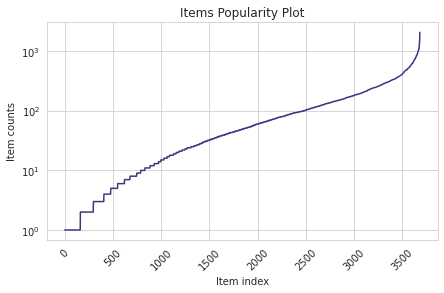

In [28]:
ds.plot_item_popularity()

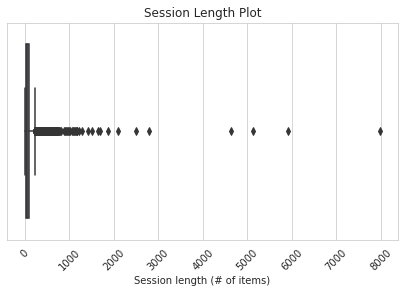

In [29]:
ds.plot_session_length()

In [36]:
ds.filter_short_sessions(min_session_length=5)

In [32]:
ds.info()

Minimum session length: 	5
Maximum session length: 	7983
Mean session length: 	 	98.46
Median session length: 	 	45
Total number of purchases: 	406253


In [38]:
train, val, test = ds.get_split_next_event_prediction(test_size=1000)

In [40]:
len(train), len(val), len(test)

(4126, 1000, 1000)